In [84]:
from functions.pre_process_baci import pre_process_data
from functions.nx_tools import whits
import pickle
import seaborn as sns
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

sns.set_style('darkgrid')

# iSKIP THIS PART

In [2]:
# data = pre_process_data('BACI_HS12_V202102')

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Start reading files...


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:32<00:00,  4.07s/it]


Reading files completed...
Start getting Country Code and HS Codes online...


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Getting Country Code and HS Codes online completed...
Start mapping Country Code and HS Codes to each df...


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Mapping Country Code and HS Codes to each df completed...
Start replacing faulty country names...


 25%|█████████████████████                                                               | 2/8 [00:00<00:01,  4.91it/s]

Replacing faulty country names completes...
Start getting Lat/long for each country...


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.55s/it]


Mapping lat/long for each country in df completed...


In [6]:
# with open('baci/data.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
with open('baci/data.pickle', 'rb') as handle:
    data = pickle.load(handle)

# SCORES

In [90]:
df_baci_2019 = data['Y2019']
vals_2019 = (
    df_baci_2019
    .groupby(['exporter', 'importer'])['value_kUSD']
    .sum()
    .reset_index())
G = nx.from_pandas_edgelist(
    vals_2019, source='exporter', target='importer', edge_attr='value_kUSD',
    create_using=nx.DiGraph())
whubs, wauth = whits(G, weight='value_kUSD')
hubs, auth = nx.hits(G)
scores_2019 = pd.concat([
    pd.DataFrame(G.out_degree, columns=['key', 'out_degree']).set_index('key'),
    pd.DataFrame(G.in_degree, columns=['key', 'in_degree']).set_index('key'),
    pd.DataFrame(pd.Series(whubs).rename('whub_score')),
    pd.DataFrame(pd.Series(wauth).rename('waut_score')),
    pd.DataFrame(pd.Series(hubs).rename('hub_score')),
    pd.DataFrame(pd.Series(auth).rename('aut_score'))
], axis=1)
norm_scores_2019 = scores_2019/scores_2019.sum()
norm_scores_2019

,out_degree,in_degree,whub_score,waut_score,hub_score,aut_score
Afghanistan,0.003642,0.002970,4.283307e-05,2.082868e-04,0.004132,0.003474
Argentina,0.005870,0.006401,2.222062e-03,2.942726e-03,0.005817,0.006147
Armenia,0.004137,0.006224,7.601330e-05,2.220801e-04,0.004461,0.006039
Australia,0.007320,0.007426,1.451423e-02,1.630189e-02,0.006388,0.006598
Austria,0.007461,0.007426,7.316578e-03,8.220935e-03,0.006498,0.006654
...,...,...,...,...,...,...
San Marino,0.003076,0.002157,5.165209e-06,8.747082e-06,0.003524,0.002604
Sao Tome and Principe,0.002016,0.001697,6.683877e-07,2.705686e-06,0.002406,0.002049
Tokelau,0.002900,0.001061,5.389378e-07,1.359329e-07,0.003314,0.001296
Br. Indian Ocean Terr.,0.001521,0.000743,3.260802e-07,1.752169e-06,0.001804,0.000917


In [102]:
for col in norm_scores_2019:
    norm_scores_2019.nlargest(10, col)[col].to_csv(f'{col}.csv')

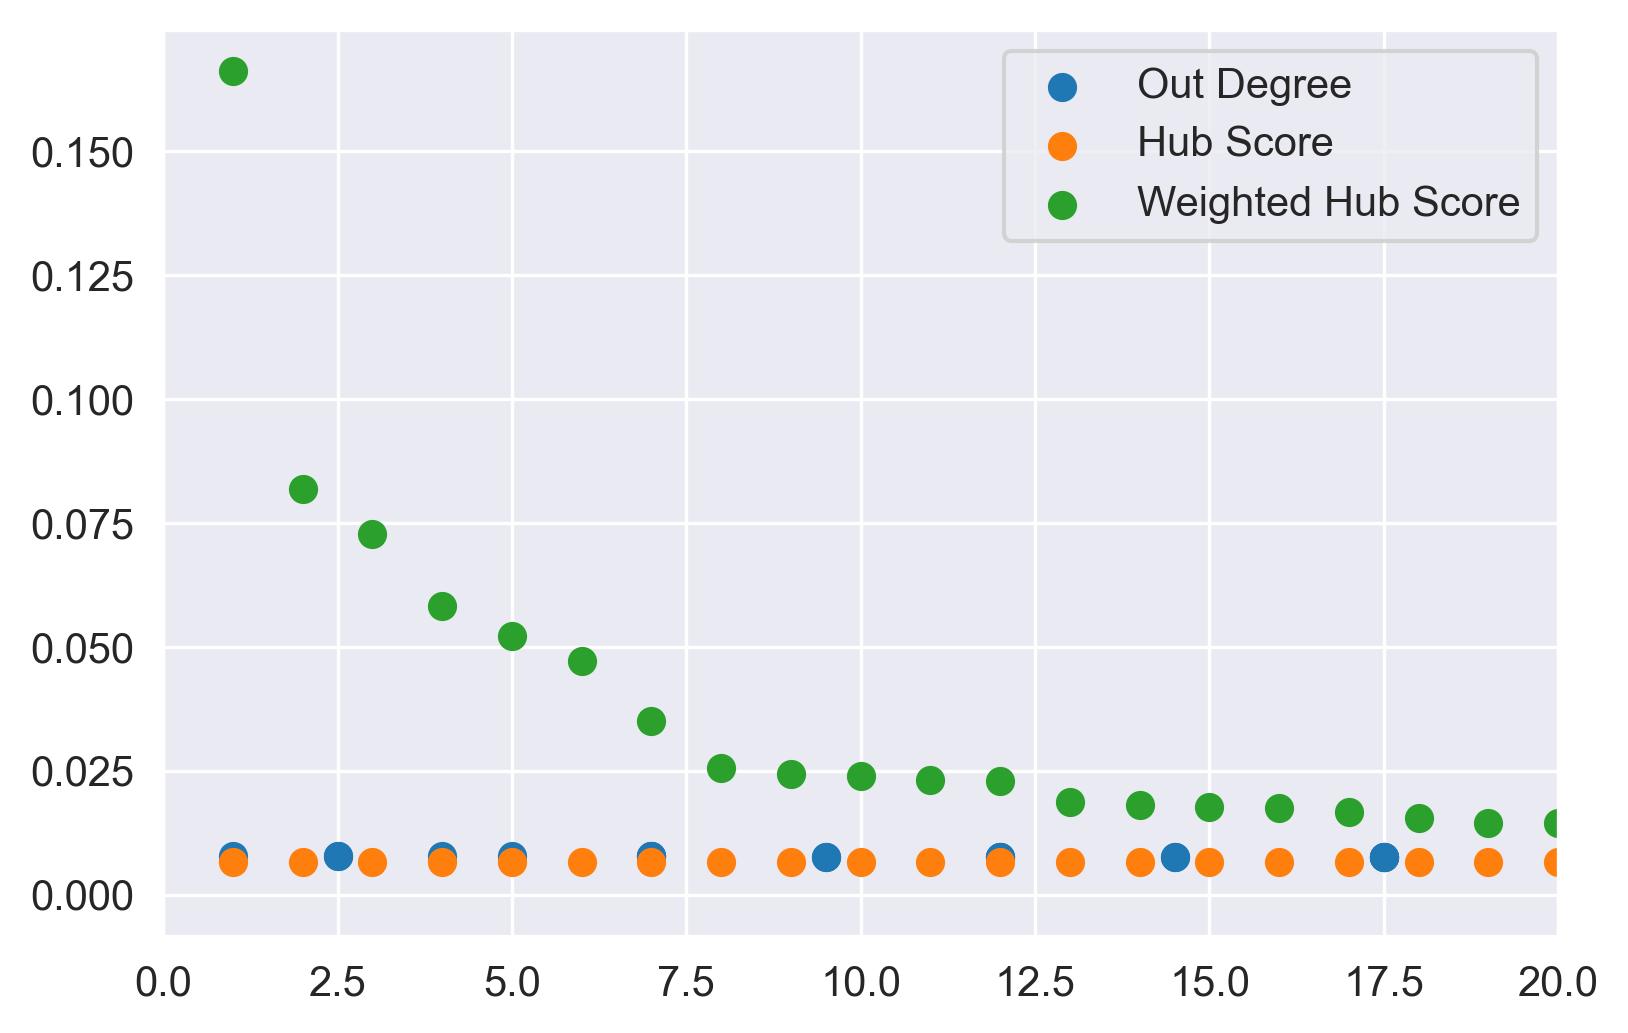

In [94]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    (-norm_scores_2019.out_degree).rank(), norm_scores_2019.out_degree,
    label='Out Degree')
ax.scatter(
    (-norm_scores_2019.hub_score).rank(), norm_scores_2019.hub_score,
    label='Hub Score')
ax.scatter(
    (-norm_scores_2019.whub_score).rank(), norm_scores_2019.whub_score,
    label='Weighted Hub Score')
ax.set_xlim(0, 20)
ax.legend()

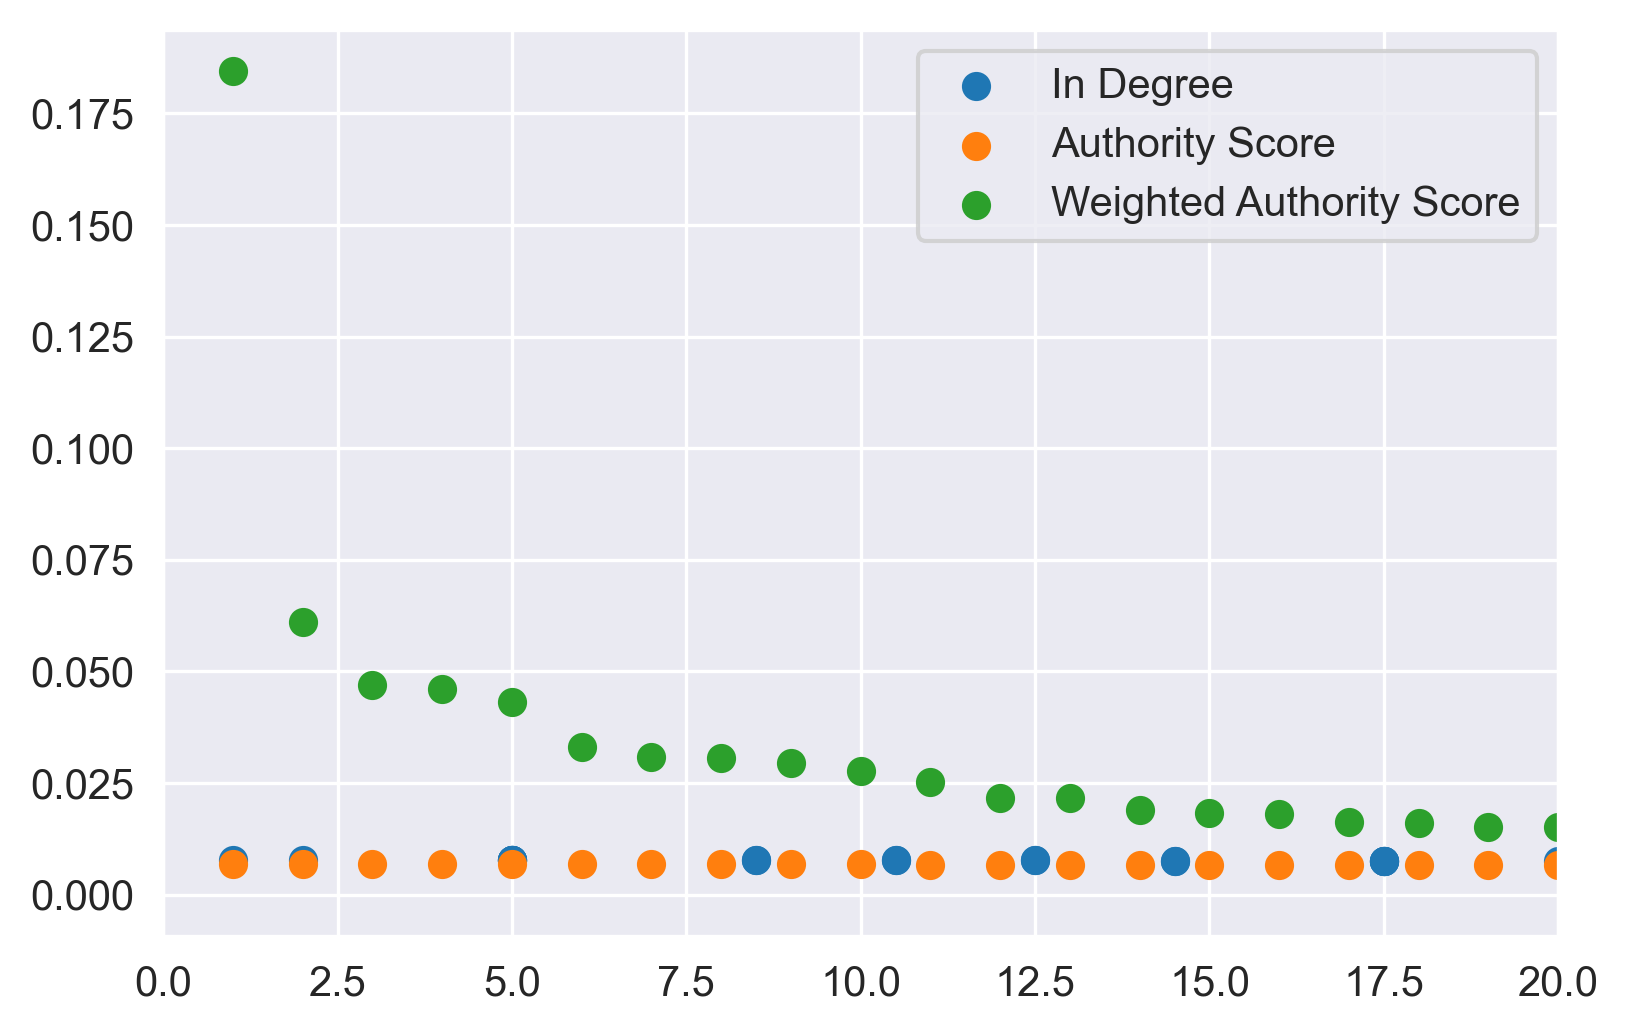

In [95]:
fig, ax = plt.subplots(dpi=300)
ax.scatter(
    (-norm_scores_2019.in_degree).rank(), norm_scores_2019.in_degree,
    label='In Degree')
ax.scatter(
    (-norm_scores_2019.aut_score).rank(), norm_scores_2019.aut_score,
    label='Authority Score')
ax.scatter(
    (-norm_scores_2019.waut_score).rank(), norm_scores_2019.waut_score,
    label='Weighted Authority Score')
ax.set_xlim(0, 20)
ax.legend()

# ZA WURDO

In [13]:
df_baci_2017 = data['Y2017']
df_baci_2018 = data['Y2018']
df_baci_2019 = data['Y2019']

df_total_trade = df_baci_2019[['exporter', 'importer', 'hscode',
              'value_kUSD','quantity_mtons']].groupby(['exporter', 
                                                       'importer']).sum()
df_tot_trade = df_total_trade.reset_index()
df_tot_trade = df_tot_trade[~(df_tot_trade.importer=='Other Asia, nes') 
                            & ~(df_tot_trade.exporter=='Other Asia, nes')]

# Creating exporter-centric details
df_exporter = df_tot_trade.groupby('exporter').sum()
df_exporter['proportion_of_world_trade'] = df_exporter.value_kUSD/df_exporter.value_kUSD.sum()
df_exporter = df_exporter.reset_index()

conditions = [
    (df_exporter['value_kUSD'] <= 50_000_000), # <= USD 50 B
    (df_exporter['value_kUSD'] > 50_000_000) & (df_exporter['value_kUSD'] <= 150_000_000),
    (df_exporter['value_kUSD'] > 150_000_000) & (df_exporter['value_kUSD'] <= 500_000_000),
    (df_exporter['value_kUSD'] > 500_000_000)
    ]
values = ['< USD 50 B', 'USD 50-150 B', 'USD 150-500 B', '> USD 500 B']

df_exporter['value_tier'] = np.select(conditions, values)

# creating node size
df_exporter['size_of_node'] = df_exporter['proportion_of_world_trade']*100000
node_size = dict(zip(df_exporter['exporter'], df_exporter['size_of_node'].apply(int)))

# creating dict of long-lat
from geopy.geocoders import Nominatim
countries_list = df_tot_trade.importer.unique()
long_lat_dict = dict()
for country in countries_list:
    geolocator = Nominatim(user_agent="map_locator")
    location = geolocator.geocode(country)
    if location is not None:
        long_lat_dict[country] = (location.longitude, location.latitude)

# creating labels
label_basis_dict = dict(zip(df_exporter['exporter'], df_exporter['value_tier']))
labels = {country: country if label_basis_dict[country] == '> USD 500 B' else ''
          for country in label_basis_dict.keys()}

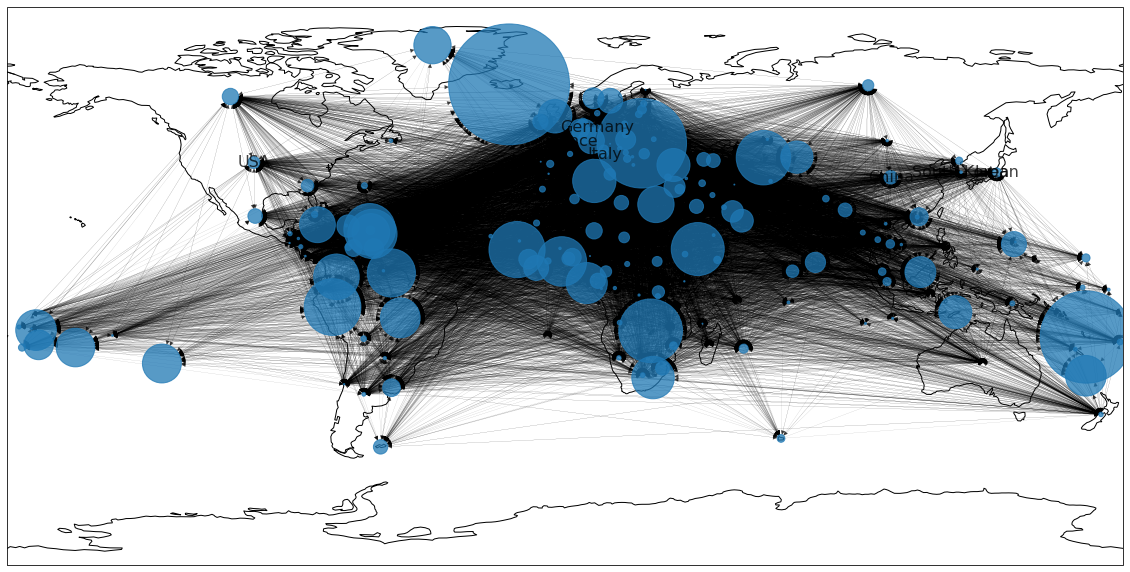

In [17]:
G_tot = nx.Graph()
pos = nx.circular_layout(G_tot)
G_tot = nx.from_pandas_edgelist(df_tot_trade, 
                            source='exporter', 
                            target='importer',
                            edge_attr=['value_kUSD', 'quantity_mtons'],
                            create_using = nx.DiGraph())

# Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 1, figsize=(20, 15),
                       subplot_kw=dict(projection=crs))
ax.coastlines()
ax.set_global()
nx.draw_networkx(G_tot, ax=ax,
                 font_size=16,
                 alpha=.75,
                 width=.075,
                 node_size=list(node_size.values()),
                 labels=labels,
                 pos=long_lat_dict,
                 cmap=plt.cm.autumn)

In [97]:
df_baci_2019.value_kUSD.max()

63331392.319

In [106]:
f'{sum([d.size for d in data.values()]):,}'

'914,686,223'

In [108]:
np.average([d.size for d in data.values()])

114335777.875